## ORF401: Bowling Simulation
Instructor: Professor Kornhauser <br>
Due date: 3/09/21, Tuesday by 23:59 <br>
Student: Maximilian Sporer <br>
NetID: msporer <br>

In [690]:
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
import pandas as pd
import cvxpy as cp
from collections import Counter
pd.set_option("display.max_columns",None)

### Uniform
As an initial attempt, let's use the Uniform distribution.<br><br>
$
\begin{align}
\quad \quad \text{Let } & R_{i,j} \text{ be pins knocked downed in frame $i$ by roll $j$} \\
&i \in \{1,\ldots,10\} \text{ indexes into n}\\
&j \in \begin{cases} \{1,2\} & \text{if $i \neq 10$} \\ \{1,2,3\} & \text{if $i = 10$} \\ \end{cases} \text{ indexes into m} \\ \space \\
\text{Let } & R_{i,j} \in \{0,1,\ldots,10\} \\
& R_{i,j} \sim U[0,10] \quad \forall i,j \\ \space \\
\end{align}
$

#### Bowling Simulation

In [861]:
sim_bowling_uniform()

(array([[10,  0,  0],
        [ 4,  0,  0],
        [ 1,  2,  0],
        [10,  0,  0],
        [ 6,  4,  0],
        [ 0,  5,  0],
        [ 3,  5,  0],
        [ 5,  4,  0],
        [ 2,  2,  0],
        [ 2,  4,  0]]),
 array([10,  4,  3, 10, 10,  5,  8,  9,  4,  6]))

In [700]:
# instantiate rolls and score arrays for storage
def sim_bowling_uniform():
    rolls = np.array([[-1]*3]*10)

    n = rolls.shape[0]
    m = rolls.shape[1]
    score = np.array([-1]*10)

    ############# first frame #############
    # 1st bowl
    rolls[0][0] = np.random.randint(0,11)

    # 2nd bowl
    if (rolls[0][0] == 10): # strike
        rolls[0][1] = 0
    else:
        rolls[0][1] = np.random.randint(0,11-rolls[0][0])

    # 3rd bowl
    rolls[0][2] = 0

    # scoring
    score[0] = np.sum(rolls[0])
    ############# first frame #############

    ############# for frames 2-9 ##########
    for i in range(1,n-1): 
        # 1st bowl
        rolls[i][0] = np.random.randint(0,11)

        # 2nd bowl
        if (rolls[i][0] == 10): # strike
            rolls[i][1] = 0

        else:
            rolls[i][1] = np.random.randint(0,11-rolls[i][0])

        # 3rd bowl
        rolls[i][2] = 0

        # scoring
        score[i] = np.sum(rolls[i])

    ############# for frames 2-9 ##########

    ############## last frame #############
    # 1st bowl
    rolls[9][0] = np.random.randint(0,11)

    # 2nd bowl
    # 1st bowl was strike so reset rack
    if (rolls[9][0] == 10): 
        rolls[9][1] = np.random.randint(0,11)
        # 2nd bowl was a strike so reset rack
        if (rolls[9][1] == 10): 
            rolls[9][2] = np.random.randint(0,11)
        else:
            rolls[9][2] = np.random.randint(0,11-rolls[9][1])
    else:
        rolls[9][1] = np.random.randint(0,11-rolls[9][0])
        if (np.sum(rolls[9][:2])==10):
            rolls[9][2] = np.random.randint(0,11)

    if not (np.sum(rolls[9][:2]) >= 10):
        rolls[9][2] = 0

    score[9] = np.sum(rolls[9])
    
    return rolls,score

In [701]:
def compound_score(rolls,score):
    for i in range(1,9):
        # last bowl was a spare
        if (np.sum(rolls[i-1]) == 10 and rolls[i-1][0] != 10):
            score[i-1] += rolls[i][0]
        # last bowl was a strike
        if (rolls[i-1][0] == 10):
            score[i-1] += rolls[i][0]
            if (rolls[i][0] == 10):
                score[i-1] += rolls[i+1][0]
            else:
                score[i-1] += rolls[i][1]

    # last frame
    # last bowl was a spare
    if (np.sum(rolls[8]) == 10 and rolls[8][0] != 10):
        score[8] += rolls[9][0]
    # last bowl was a strike
    if (rolls[8][0] == 10):
        score[8] += rolls[9][0] + rolls[9][1]

    return score

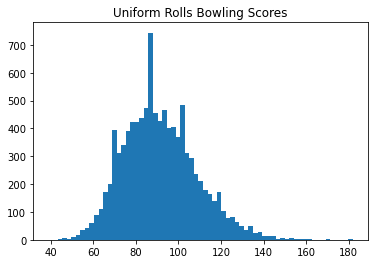

max:  182
min:  39
mean: 91
mode: 86


In [704]:
n_sim = 10000
scores = []
for i in range(n_sim):
    ret = sim_bowling_uniform()
    score = np.sum(compound_score(ret[0],ret[1]))
    scores.append(score)
plt.hist(scores,bins='auto')
plt.title("Uniform Rolls Bowling Scores")
plt.show()
print("max: ",max(scores))
print("min: ",min(scores))
print("mean:",stats.mean(scores))
print("mode:",stats.mode(scores))

### Normal
Now lets try the using the normal distribution. Set $\sigma$ so that 95% of bowls are between 0 10. Round up and down if less than 0 or greater than 10, respectively.<br><br>
$
\begin{align}
\quad \quad \text{Let } R_{i,j} \sim \mathcal{N}(5,10) \quad \forall i,j \\ \space \\
\end{align}
$

In [705]:
def knockdown_normal(maxpins=10):
    m = maxpins/2
    s = (maxpins-m)/3
    roll = np.round(np.random.normal(m,s))
    if roll < 0:
        roll = 0
    if roll > maxpins:
        roll = maxpins
    return roll

In [706]:
def sim_bowling_normal():
    rolls = np.array([[-1]*3]*10)

    n = rolls.shape[0]
    m = rolls.shape[1]
    score = np.array([-1]*10)

    ############# first frame #############
    # 1st bowl
    rolls[0][0] = knockdown_normal()

    # 2nd bowl
    if (rolls[0][0] == 10): # strike
        rolls[0][1] = 0
    else:
        rolls[0][1] = knockdown_normal(10-rolls[0][0])

    # 3rd bowl
    rolls[0][2] = 0

    # scoring
    score[0] = np.sum(rolls[0])
    ############# first frame #############

    ############# for frames 2-9 ##########
    for i in range(1,n-1): 
        # 1st bowl
        rolls[i][0] = knockdown_normal()

        # 2nd bowl
        if (rolls[i][0] == 10): # strike
            rolls[i][1] = 0

        else:
            rolls[i][1] = knockdown_normal(10-rolls[i][0])

        # 3rd bowl
        rolls[i][2] = 0

        # scoring
        score[i] = np.sum(rolls[i])

    ############# for frames 2-9 ##########

    ############## last frame #############
    # 1st bowl
    rolls[9][0] = knockdown_normal()

    # 2nd bowl
    # 1st bowl was strike so reset rack
    if (rolls[9][0] == 10): 
        rolls[9][1] = knockdown_normal()
        # 2nd bowl was a strike so reset rack
        if (rolls[9][1] == 10): 
            rolls[9][2] = knockdown_normal()
        else:
            rolls[9][2] = knockdown_normal(10-rolls[9][1])
    else:
        rolls[9][1] = knockdown_normal(10-rolls[9][0])
        if (np.sum(rolls[9][:2])==10):
            rolls[9][2] = knockdown_normal()

    if not (np.sum(rolls[9][:2]) >= 10):
        rolls[9][2] = 0

    score[9] = np.sum(rolls[9])
    
    ############## last frame #############
    
    return rolls,score

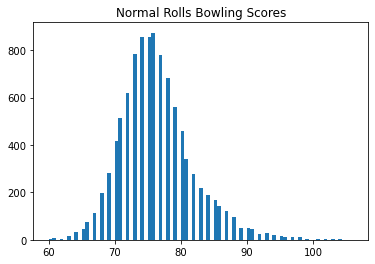

max:  106
min:  60
mean: 76
mode: 76


In [707]:
n_sim = 10000
scores = []
for i in range(n_sim):
    ret = sim_bowling_normal()
    score = np.sum(compound_score(ret[0],ret[1]))
    scores.append(score)
plt.hist(scores,bins='auto')
plt.title("Normal Rolls Bowling Scores")
plt.show()
print("max: ",max(scores))
print("min: ",min(scores))
print("mean:",stats.mean(scores))
print("mode:",stats.mode(scores))

### Professional Bowling Data
I emailed the author of this article and asked him for the data. It includes 447,000 professional bowling games scraped from PBA.com.<br>
http://www.slate.com/articles/sports/sports_nut/2015/02/hardest_shot_in_bowling_it_s_not_the_7_10_split_it_s_the_greek_church.html

#### Cleaning

In [708]:
df = pd.read_csv('bowling.csv',header=None)

In [255]:
bad_games = []
for i in range(df.shape[0]):
    if list(df.iloc[i][1:].unique()) == [" ''"]:
        bad_games.append(i)

In [304]:
df2 = df.drop(bad_games)
df2 = df2.reset_index(drop=True)
df2.to_csv('data_fixed.csv')

In [463]:
#empty = []
bad = []
for i in range(df2.shape[0]):
    codes = df2.iloc[i][1:].value_counts().index
    if " ''" in codes:
        count = df2.iloc[i][1:].value_counts()[" ''"]
        if (count >= 10):
            bad.append(i)
        #empty.append(df2.iloc[i][1:].value_counts()[" ''"])

In [467]:
# Counter(empty)
df3 = df2.drop(bad)
df3 = df3.reset_index(drop=True)
df3.to_csv('data_fixed2.csv')

In [709]:
df3.shape[0]

42325

After cleaning the data, only 42,325 games are usable.

#### Spare Success Machine
The author of the previously linked article (Ben Blatt) created a "Spare Success Machine" which shows the percentage in which certain configurations were converted to spares. This is a bit of a detour but in order to decode the data and ensure it was similar I checked some of the configurations. Below are some functions for checking.

In [854]:
# pin weights
pins = []
for i in range(0,10):
    pins.append(2**i)
pins = np.array(pins_0)

def pin_decode(c):
    if c>1023:
        c-=1024
        
    x = cp.Variable(pins.shape[0],boolean=True)
    obj = cp.Minimize(0)
    constraints = [pins@x>=c,
                   pins@x<=c]
    prob = cp.Problem(obj, constraints)
    prob.solve()
    return x.value

# configuration
# 6 7 8 9
#  3 4 5 
#   1 2
#    0
def pin_encode(p):
    x = np.zeros(10)
    for i in p:
        x[i] = 1
    return int(np.sum(x*pins))

def split_to_spare(p):
    c = pin_encode(p)
    fix = 1024
    splits = 0
    convert = 0
    j=1
    while(j<=19):
        roll1 = df2[j]
        roll2 = df2[j+1]
        for i in range(roll1.shape[0]):
            a = roll1[i]
            if (a != " ''") and (a != " 'X'"):
                if (int(a) in [c,c+fix]):
                    splits += 1
                    if (roll2[i] == " '/'"):
                        convert += 1
        j+=2
        
    return convert/splits

And here are some examples.

![6pinconfig](6pinconfig.png)

In [714]:
print("{:.1f}%".format(100*split_to_spare([6])))

96.0%


![7-10pinconfig](7-10pinconfig.png)

In [715]:
print("{:.1f}%".format(100*split_to_spare([6,9])))

0.7%


![rgreekchurch](rgreekchurch.png)

In [716]:
print("{:.1f}%".format(100*split_to_spare([3,5,6,8,9])))

0.3%


![lgreekchurck](lgreekchurch.png)

In [717]:
print("{:.1f}%".format(100*split_to_spare([3,5,6,7,9])))

1.4%


The last 3 configurations included are the infamous 7-10 split and two configurations of the "greek church" (right greek church and left greek church, in order of appereance). The percentages generated are a bit off but are close enough I feel.
<br><br>What is interesting is that the greek church in which 3 pins are clustered on the right is ostensibly a more difficult configuration to convert to a spare than the 7-10 split. Ben Blatt notes that the right greek church was converted to spares the least of all configurations. However, some of the comments on the article posted by avid bowling fans note that professional bowlers may simply be aiming for the cluster of 3 pins as opposed to going for a spare because it is a safer option.<br><br>Another interesting note is that the right and left greek churches have different spare conversion percentages. The comments remark that this may be due to the difference in right and left handed bowlers. Assuming there are more right handed bowlers, the left greek church is easier to convert to a spare for righties.

#### Score Distribution
The below linked paper by Douglas VanDerwerken and Franklin Kenter titled "A generative Markov model for bowling scores" (2018) used the same data I acquired from Ben Blatt.<br>
https://www.degruyter.com/document/doi/10.1515/jqas-2017-0081/html<br><br>
Below, I attempt to recreate the histogram of scores included in the above paper.

In [720]:
def game_to_score(game):
    score = np.array([-1]*10)
    if (game[1] == " '/'" or game[1] == " 'X'"):
        score[0] = 10
    elif (game[1] != " ''"):
        score[0] = np.sum(1-pin_decode(int(game[1])))
    elif (game[0] != " ''"):
        score[0] = np.sum(1-pin_decode(int(game[0])))
    else:
        score[0] = 0

    # frames 1 through 9
    for i in list(np.arange(3,len(game[2:-1]),2)):
        
        j = int((i-1)/2)
        #print(j)
        if (game[i] == " '/'" or game[i] == " 'X'"):
            score[j] = 10
        else:
            if (game[i] == " ''"):
                if (game[i-1] == " ''"):
                    score[j] = 0
                else:
                    score[j] = np.sum(1-pin_decode(int(game[i-1])))
            else:
                score[j] = np.sum(1-pin_decode(int(game[i])))

        # last bowl was a strike or spare
        if (score[j-1] == 10):
            score[j-1] += score[j]

        # bowl before last was a strike
        if (j>=2 and game[i-2] == " 'X'"):
            score[j-2] += score[j]
#         print(game[i-2])
#         print(score)

    # last frame
    #print("last frame")
    # 1st bowl strike
    if (game[18] == " 'X'"):
        score[9] = 10
        # 2nd bowl strike
        if (game[19] == " 'X'"):
            score[9] += 10
            # 3nd bowl strike
            if (game[20] == " 'X'"):
                score[9] += 10
            elif (game[20] != " ''"):
                score[9] += np.sum(1-pin_decode(int(game[20])))
        elif (game[19] == " ''"):
            if (game[20] == " 'X'"):
                score[9] += 10
            elif (game[20] != " ''"):
                score[9] += np.sum(1-pin_decode(int(game[20])))
                
        elif (game[20] == " '/'"):
            score[9] += 10
        elif (game[19] != " ''"):
            if (game[20] != " ''"):
                score[9] += np.sum(1-pin_decode(int(game[20])))
        elif (game[20] == " ''"):
            if (game[19] != " ''"):
                score[9] += np.sum(1-pin_decode(int(game[19])))
    elif (game[19] == " '/'"):
        score[9] = 10
        if (game[20] == " 'X'"):
            score[9] += 10
        elif (game[20] != " ''"):
            score[9] += np.sum(1-pin_decode(int(game[20])))
    elif (game[18] == " ''"):
        if (game[19] != " ''"):
            score[9] = np.sum(1-pin_decode(int(game[19])))
    elif (game[18] != " ''"):
        if (game[19] == " ''"):
            score[9] = np.sum(1-pin_decode(int(game[18])))
    #print(score)
    # previous bowls scoring
    
    # first bowl score
    if (game[18] == " 'X'"):
        first_bowl = 10
    elif (game[18] != " ''"):
        first_bowl = np.sum(1-pin_decode(int(game[18])))
    else:
        first_bowl = 0
    
    # second bowl score
    if (game[19] == " 'X'"):
        second_bowl = 10
    elif (game[19] == " '/'"):
        second_bowl = 10 - first_bowl
    elif (game[19] != " ''"):
        second_bowl = np.sum(1-pin_decode(int(game[19])))
    else:
        second_bowl = 0
        
    # 9th bowl was a spare
    if (game[17] == " '/'"):
        score[8] += first_bowl
    if (game[17] == " 'X'"):
        score[8] += first_bowl + second_bowl
    
    # 8th bowl was a strike
    if (game[15] == " 'X'"):
        score[7] += first_bowl

    return(np.sum(score))

In [721]:
scores = []
for i in range(df3.shape[0]):
    game = list(df3.iloc[i])[1:]
    scores.append(game_to_score(game))

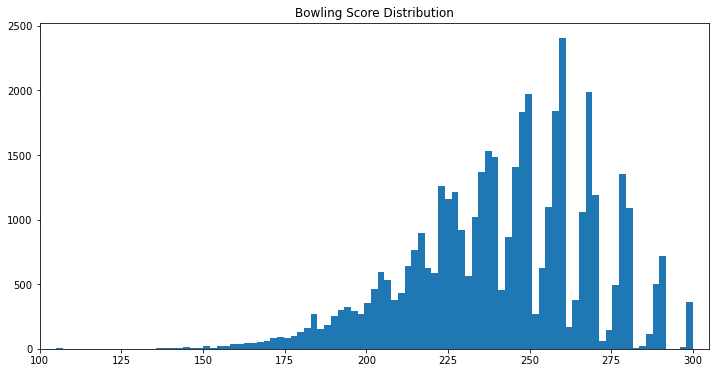

max:  300
min:  29
mean: 241
mode: 259


In [722]:
plt.figure(figsize=(12,6))
plt.hist(scores,bins='auto')
plt.title("Bowling Score Distribution")
plt.xlim([100,305])
plt.show()
print("max: ",max(scores))
print("min: ",min(scores))
print("mean:",stats.mean(scores))
print("mode:",stats.mode(scores))

Pictured above is the histogram I generated from the data and below is the histogram included in the previously linked paper.

![scoredist](scoredist.jpeg)

As described by VanDerwerken and Kenter, the distribution of bowling scores is uniquely mulitmodal. Past scores of 200, we see peaks in frequency at scores that are multiples of 10, increasing in size relative to neighboring scores (this can be more closely observed in the scores printed below). This distribution may be attributable to both bowling's unique scoring system and "the fact that elite bowlers typically knock down 9 or 10 pins per frame instead of, say, 0 or 1" (VanDerwerken and Kenter 2018).

In [613]:
score_freq = Counter(scores)
for i in sorted(score_freq.items()):
    print(i)

(29, 1)
(106, 2)
(107, 1)
(111, 1)
(114, 1)
(115, 1)
(128, 1)
(130, 1)
(133, 1)
(134, 1)
(135, 1)
(137, 3)
(138, 3)
(139, 2)
(140, 2)
(141, 6)
(142, 5)
(143, 3)
(144, 4)
(145, 4)
(146, 3)
(147, 4)
(148, 6)
(149, 6)
(150, 4)
(151, 9)
(152, 14)
(153, 4)
(154, 4)
(155, 10)
(156, 9)
(157, 11)
(158, 12)
(159, 25)
(160, 16)
(161, 17)
(162, 20)
(163, 20)
(164, 24)
(165, 17)
(166, 28)
(167, 26)
(168, 23)
(169, 28)
(170, 32)
(171, 41)
(172, 43)
(173, 44)
(174, 46)
(175, 47)
(176, 33)
(177, 44)
(178, 58)
(179, 61)
(180, 69)
(181, 88)
(182, 76)
(183, 88)
(184, 82)
(185, 100)
(186, 82)
(187, 73)
(188, 75)
(189, 113)
(190, 111)
(191, 140)
(192, 155)
(193, 149)
(194, 168)
(195, 153)
(196, 165)
(197, 131)
(198, 149)
(199, 120)
(200, 158)
(201, 195)
(202, 218)
(203, 245)
(204, 286)
(205, 311)
(206, 283)
(207, 247)
(208, 219)
(209, 162)
(210, 204)
(211, 225)
(212, 300)
(213, 341)
(214, 330)
(215, 437)
(216, 442)
(217, 452)
(218, 344)
(219, 280)
(220, 312)
(221, 275)
(222, 336)
(223, 435)
(224, 488)
(22

### Score Distributions of Individual Players
Because this dataset has tagged each game with the player who bowled them, we can look at score distributions for individual players. Here a couple examples from especially active players.

In [676]:
df3[0].value_counts()

Chris Barnes               1177
Walter Ray Williams Jr.    1125
Tommy Jones                1051
Patrick Allen               967
Brad Angelo                 942
                           ... 
Frankie Calca                 1
Johnathan Bower               1
Kenneth Kempf                 1
Brad Miller                   1
Kimmo Lehtonen                1
Name: 0, Length: 434, dtype: int64

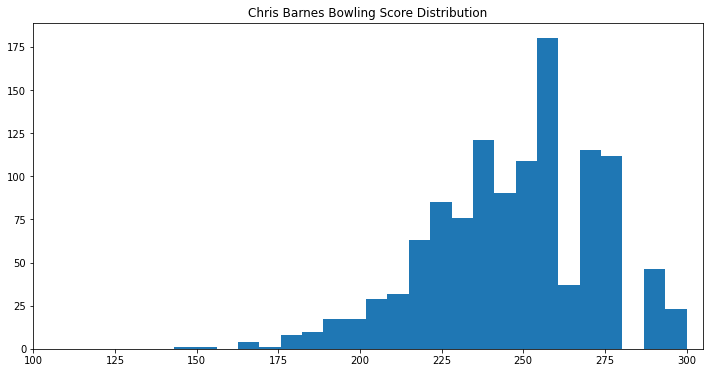

max:  300
min:  143
mean: 247
mode: 259


In [732]:
chris = list(df3[df3[0] == 'Chris Barnes'].index)

scores = []
for i in chris:
    game = list(df3.iloc[i])[1:]
    scores.append(game_to_score(game))

plt.figure(figsize=(12,6))
plt.hist(scores,bins='auto')
plt.title("Chris Barnes Bowling Score Distribution")
plt.xlim([100,305])
plt.show()
print("max: ",max(scores))
print("min: ",min(scores))
print("mean:",stats.mean(scores))
print("mode:",stats.mode(scores))

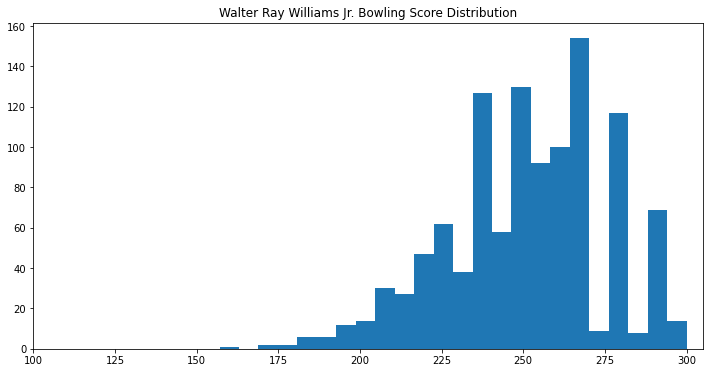

max:  300
min:  157
mean: 251
mode: 280


In [733]:
walter = list(df3[df3[0] == 'Walter Ray Williams Jr.'].index)

scores = []
for i in walter:
    game = list(df3.iloc[i])[1:]
    scores.append(game_to_score(game))

plt.figure(figsize=(12,6))
plt.hist(scores,bins='auto')
plt.title("Walter Ray Williams Jr. Bowling Score Distribution")
plt.xlim([100,305])
plt.show()
print("max: ",max(scores))
print("min: ",min(scores))
print("mean:",stats.mean(scores))
print("mode:",stats.mode(scores))

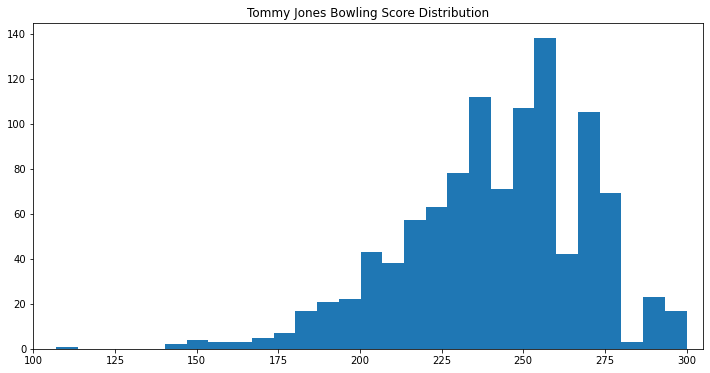

max:  300
min:  107
mean: 241


In [735]:
tommy = list(df3[df3[0] == 'Tommy Jones'].index)

scores = []
for i in tommy:
    game = list(df3.iloc[i])[1:]
    scores.append(game_to_score(game))

plt.figure(figsize=(12,6))
plt.hist(scores,bins='auto')
plt.title("Tommy Jones Bowling Score Distribution")
plt.xlim([100,305])
plt.show()
print("max: ",max(scores))
print("min: ",min(scores))
print("mean:",stats.mean(scores))
#print("mode:",stats.mode(scores)) # no unique mode

### Simulating Bowling Games using Empirical Distribution
In order to simulate a single game of bowling, I plan on deriving probabilities of every possible roll from the data.

In [781]:
# first roll of frames
i = 1
frames = []
while (i <= 17):
    frames += list(df3[i])
    i+=2

# value counts
first_bowls = Counter(frames)

# normalization
total = 0
for v in first_bowls.values():
    total += v

normal_first_bowls = {k: v / total for k, v in first_bowls.items()}

# percentage of strikes vs misses
i = 1
double_frames = []
while (i <= 17):
    double_frames += tuple(zip(list(df3[i]),list(df3[i+1])))
    i+=2
    
strikes_percentage = Counter(double_frames)[(" ''", " 'X'")]/(
    Counter(double_frames)[(" ''", " ''")]+Counter(double_frames)[(" ''", " 'X'")])

normal_first_bowls[" 'X'"] = strikes_percentage*normal_first_bowls[" ''"]
normal_first_bowls[" ''"] -= normal_first_bowls[" 'X'"]
# print("unique pin configurations :",len(first_bowls))

# sort
normal_first_bowls = {k: v for k, v in sorted(normal_first_bowls.items(), key=lambda item: item[1])}

#normal_first_bowls

In [782]:
# convert normal_first_bowls to a CDF
uniq_bowls = list(normal_first_bowls.keys())
for i in range(1,len(uniq_bowls)):
    normal_first_bowls[uniq_bowls[i]] += normal_first_bowls[uniq_bowls[i-1]]

In [812]:
# invert normal_first_bowls
inv = {}
for k,v in normal_first_bowls.items():
    inv[v] = k

inv = SortedDict(inv)

# Now for the actual simulation
def sim_first_bowl():
    x = np.random.uniform()
    pos = inv.bisect(x)
    return inv[inv.iloc[pos]]

In [913]:
def emp_sim_bowling():
    rolls = np.array([[-1]*3]*10)
    score = np.array([-1]*10)

    for i in range(9):
        bowl = sim_first_bowl()

        # STRIKE
        if bowl == " 'X'":
            rolls[i][0]=10
            rolls[i][1]=0
            #print("STRIKE")
        # Potential Spare
        else:
            pinconfig = list(np.where(pin_decode(int(bowl))==1))
            if bowl == " ''":
                pinconfig = list(np.where(np.ones(10)==1))
            pins_left = len(list(pinconfig[0]))
            rolls[i][0] = 10-pins_left
            spare_prob = split_to_spare(pinconfig)
            x = np.random.uniform()
            if (x <= spare_prob):
                rolls[i][1] = pins_left
            elif (pins_left == 1):
                rolls[i][1] = 0
            else:
                rolls[i][1] = np.random.randint(0,pins_left-1)
            #print(list(pinconfig[0]))
        rolls[i][2] = 0
        score[i] = np.sum(rolls[i])

    # Last frame
    # First bowl
    bowl = sim_first_bowl()
    # Strike
    if bowl == " 'X'":
        rolls[9][0] = 10
        bowl = sim_first_bowl()
        # two more bowls Strike
        if bowl == " 'X'":
            rolls[9][1] = 10
            # one more bowl
            bowl = sim_first_bowl()
            if bowl == " 'X'":
                rolls[9][2] = 10
            else:
                pins_left = len(list(pinconfig[0]))
                rolls[9][2] = 10-pins_left
        # two more bowls spare
        else:
            pinconfig = list(np.where(pin_decode(int(bowl))==1))
            if bowl == " ''":
                pinconfig = list(np.where(np.ones(10)==1))
            pins_left = len(list(pinconfig[0]))
            rolls[i][0] = 10-pins_left
            spare_prob = split_to_spare(pinconfig)
            x = np.random.uniform()
            if (x <= spare_prob):
                rolls[i][1] = pins_left
            elif (pins_left == 1):
                rolls[i][1] = 0
            else:
                rolls[i][1] = np.random.randint(0,pins_left-1)
            
    # potential spare        
    else:
        pinconfig = list(np.where(pin_decode(int(bowl))==1))
        if bowl == " ''":
            pinconfig = list(np.where(np.ones(10)==1))
        pins_left = len(list(pinconfig[0]))
        rolls[i][0] = 10-pins_left
        spare_prob = split_to_spare(pinconfig)
        x = np.random.uniform()
        if (x <= spare_prob):
            rolls[i][1] = pins_left
        elif (pins_left == 1):
            rolls[i][1] = 0
        else:
            rolls[i][1] = np.random.randint(0,pins_left-1)
    for i in range(len(rolls[9])):
        if rolls[9][i] == -1:
            rolls[9][i] = 0

    score[9] = np.sum(rolls[9])
        # 2 more rolls
    return np.sum(compound_score(rolls,score))

In [915]:
n_sim = 100
scores = []
for i in range(n_sim):
    print(i)
    score = emp_sim_bowling()
    scores.append(score)

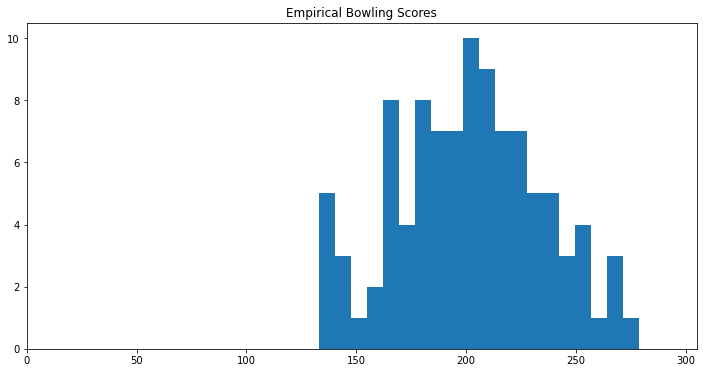

max:  279
min:  133
mean: 201


In [924]:
plt.figure(figsize=(12,6))
plt.hist(scores,bins=20)
plt.title("Empirical Bowling Scores")
plt.xlim([0,305])
plt.show()
print("max: ",max(scores))
print("min: ",min(scores))
print("mean:",stats.mean(scores))
#print("mode:",stats.mode(scores))

Shown above is the a histogram of 100 bowling scores simulated form the empirical distribution. By simulating each bowl individually, I was able to recreate the empirical distribution to a degree. The simulated distribution above does appear to be somewhat multimodal but lacks the long tail towards the lower end of scores. I am unsure of how best to improve the simulation, but certainly a larger dataset to draw from would help enrich the simulation.